# 0. 과제 개요

1. 주제: 대학별 학자금 대출 구조 불균형과 위험도 예측

2. 이번 주 목표(2주차)

       A. TASK 1: 데이터 전처리

           - 결측치·이상치 처리(선택 이유 명시)

           - 인코딩·스케일링 등 모델 적합 변환(선택)

        B. TASK 2: 피처 엔지니어링

           - 파생변수 2개 이상 생성(분석에 바로 활용 가능한 형태)

# 1. 데이터 로드 & 기본 점검

**데이터 컬럼(요약)**  
- **식별/구분**: `조사년도`, `차수`, `학기구분(1·2학기)`, `대학구분명(대학/대학원)`, `학교명`, `본분교구분`, `적용년도`  
- **규모**: `재학생수`  
- **대출**:  
  - 일반학자금(전체/등록금) → `일반학자금대출_전체_학생수/금액`, `일반학자금대출_등록금_학생수/금액`  
  - 취업후상환(전체/등록금) → `취업학자금대출_전체_학생수/금액`, `취업학자금대출_등록금_학생수/금액`  
- **생활비 파생 필요**: 명시적 생활비 항목이 없어 **전체 − 등록금 = 생활비** 로 파생


# 2. 전처리 설계

- **결측치(재학생수)**  
  - `학교명 × 대학구분명` 그룹 **중앙값**으로 대체 → 학교/과정별 규모 특성 보존  
  - 해당 그룹 중앙값이 없을 경우 **전체 중앙값**으로 보완

- **이상치(1인당 대출금액)**  
  - **윈저라이징(1~99 백분위 clip)** 적용 → 극단값 영향 완화, 모델/지표 안정성 확보

- **형 변환/인코딩**  
  - `학기구분`, `대학구분명`, `본분교구분` **원-핫 인코딩(drop_first)** → 모델 입력 준비

- **스케일링(선택)**  
  - **표준화(StandardScaler)** 예시 제공(이번 주 제출은 선택 적용)


# 3. 피처 엔지니어링 

- **생활비 파생**  
  - `일반_생활비_학생수/금액 = 일반_전체 − 일반_등록금`  
  - `취업_생활비_학생수/금액 = 취업_전체 − 취업_등록금`  
  - (등록금 합이 전체를 초과하는 이상값은 0으로 보정)

- **대출자 비율(상한)**  
  - `대출자_비율_상한 = (일반 전체 학생수 + 취업 전체 학생수) / 재학생수`  
  - 일반/취업 동시 대출 가능성으로 **상한선** 해석, `clip(0, 1)`

- **1인당 평균 대출금액**  
  - 각 유형 `금액 ÷ 학생수` (0 나눗셈 방지 로직 적용)

- **불균형 지수(핵심 지표)**  
  - 네 범주: **일반_등록금**, **일반_생활비**, **취업_등록금**, **취업_생활비**  
  - **정규화 엔트로피**  
  - **정규화 지니(선택)**  
    - 지니 불순도로 정규화하여 보조지표로 사용

- **위험군 라벨**  
  - **불균형지수(학생수 기준)** 상위 20%: **고위험**  
  - 20~50%: **중위험**  
  - 하위 50%: **저위험**


# 4. 결과 저장 / 미리보기

- **저장**: 전처리·피처엔지니어링 완료 데이터 CSV로 저장  
- **간단 점검(선택, 3종)**  
  1. `불균형지수(학생수)` 히스토그램  
  2. `1인당_일반대출금액` 히스토그램  
  3. `대학구분명`별 `1인당_취업후상환금액` 박스플롯

-----


# 1. 라이브러리 & 경로 설정

### 설명
- 분석에 필요한 기본 라이브러리(`pandas`, `numpy`) 로드 
- 데이터 경로(`DATA_PATH`)를 지정
- 결측치나 이상치 계산 시 **0으로 나누는 문제**를 방지하기 위해 `safe_div` 함수를 정의

In [22]:
# =========================
# 1) 라이브러리 & 경로 설정
# =========================
import pandas as pd
import numpy as np

DATA_PATH = "한국장학재단.csv"   

def safe_div(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    out = np.zeros_like(a, dtype=float)      # 기본값 0
    np.divide(a, b, out=out, where=(b > 0))  # b>0인 위치에서만 나눗셈 수행
    # 분모가 음수/NaN인 경우도 0 처리됨. 필요하면 아래 한 줄 추가로 NaN을 0으로:
    # out = np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)
    return out

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows)
plt.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 2. 데이터 로드 & 기본 정보

### 설명
- CSV 파일 로드
- 데이터의 크기, 컬럼명, 자료형, 결측치 현황을 확인하여 전처리 계획 수립 
- `head()`를 통해 앞부분을 미리 파악

In [23]:
# =========================
# 2) 데이터 로드 & 기본 정보
# =========================
df = pd.read_csv(DATA_PATH, encoding="utf-8")

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)

print("\n결측치 개수:\n", df.isna().sum().sort_values(ascending=False).head(10))
df.head()

Shape: (1220, 16)

Columns: ['조사년도', '차수', '학기구분', '대학구분명', '학교명', '본분교구분', '적용년도', '재학생수', '일반학자금대출_전체_학생수', '일반학자금대출_전체_금액', '일반학자금대출_등록금_학생수', '일반학자금대출_등록금_금액', '취업학자금대출_전체_학생수', '취업학자금대출_전체_금액', '취업학자금대출_등록금_학생수', '취업학자금대출_등록금_금액']

Dtypes:
 조사년도                 int64
차수                   int64
학기구분                object
대학구분명               object
학교명                 object
본분교구분               object
적용년도                 int64
재학생수               float64
일반학자금대출_전체_학생수       int64
일반학자금대출_전체_금액        int64
일반학자금대출_등록금_학생수      int64
일반학자금대출_등록금_금액       int64
취업학자금대출_전체_학생수       int64
취업학자금대출_전체_금액        int64
취업학자금대출_등록금_학생수      int64
취업학자금대출_등록금_금액       int64
dtype: object

결측치 개수:
 재학생수              12
조사년도               0
차수                 0
학기구분               0
대학구분명              0
학교명                0
본분교구분              0
적용년도               0
일반학자금대출_전체_학생수     0
일반학자금대출_전체_금액      0
dtype: int64


,조사년도,차수,학기구분,대학구분명,학교명,본분교구분,적용년도,재학생수,일반학자금대출_전체_학생수,일반학자금대출_전체_금액,일반학자금대출_등록금_학생수,일반학자금대출_등록금_금액,취업학자금대출_전체_학생수,취업학자금대출_전체_금액,취업학자금대출_등록금_학생수,취업학자금대출_등록금_금액
0,2024,1,1학기,대학원,국립강릉원주대학교,본교,2023,651.0,102,301984000,95,214584000,14,43397300,13,27397300
1,2024,1,2학기,대학,국립강릉원주대학교,본교,2023,6664.0,170,348863460,84,163263460,610,980407150,96,170907150
2,2024,1,2학기,대학원,국립강릉원주대학교,본교,2023,592.0,74,204237900,67,147987900,22,65040100,19,44040100
3,2024,1,1학기,대학,국립강릉원주대학교,본교,2023,7152.0,258,632488670,151,306438670,574,1095841369,128,235172987
4,2024,1,1학기,대학원,강원대학교,본교,2023,2729.0,423,1563307850,357,1092107850,63,201430159,49,118830159


# 3. 결측치 처리

### 설명
- `재학생수` 컬럼에서 결측치가 발견됨.  
- **처리 원칙**  
  - 같은 `학교명 × 대학구분명` 그룹의 **중앙값**으로 대체 → 학교/과정 특성을 반영 
  - 그룹 내 중앙값도 없으면 전체 중앙값으로 보완
- 이렇게 하면 데이터의 분포를 크게 왜곡하지 않고 보정 가능

In [24]:
# =========================
# 3) 결측치 처리: 재학생수
# =========================
overall_med = df['재학생수'].median()
df['재학생수'] = df.groupby(['학교명','대학구분명'])['재학생수']\
                   .transform(lambda s: s.fillna(s.median()))
df['재학생수'] = df['재학생수'].fillna(overall_med)

assert df['재학생수'].isna().sum() == 0, "재학생수 결측이 남아있음."

### A) 데이터 품질 점검

In [34]:
# =========================
# A) 품질 점검
# =========================

# 1) 중복 제거 (키 후보)
before = len(df)
key_cols = ['조사년도','차수','학기구분','대학구분명','학교명','본분교구분','적용년도']
df = df.drop_duplicates(subset=key_cols, keep='first')
after = len(df)
print(f"[중복제거] {before-after}건 제거, 현재 {after}건")

# 2) 합계 일관성(전체 = 등록금 + 생활비) 검증
def check_consistency(total, tuition, living, name):
    bad = (df[total] != (df[tuition] + df[living])).sum()
    if bad > 0:
        print(f"[경고] {name} 합계 불일치 {bad}건 (원천 확인 권장)")
    else:
        print(f"[OK] {name} 합계 일관성 통과")

check_consistency('일반학자금대출_전체_학생수','일반학자금대출_등록금_학생수','일반학자금대출_생활비_학생수','일반-학생수')
check_consistency('일반학자금대출_전체_금액','일반학자금대출_등록금_금액','일반학자금대출_생활비_금액','일반-금액')
check_consistency('취업학자금대출_전체_학생수','취업학자금대출_등록금_학생수','취업학자금대출_생활비_학생수','취업후-학생수')
check_consistency('취업학자금대출_전체_금액','취업학자금대출_등록금_금액','취업학자금대출_생활비_금액','취업후-금액')

# 3) 음수/불가능 값 검출 로그
num_cols = [
    '재학생수','일반학자금대출_전체_학생수','일반학자금대출_등록금_학생수','일반학자금대출_생활비_학생수',
    '취업학자금대출_전체_학생수','취업학자금대출_등록금_학생수','취업학자금대출_생활비_학생수',
    '일반학자금대출_전체_금액','일반학자금대출_등록금_금액','일반학자금대출_생활비_금액',
    '취업학자금대출_전체_금액','취업학자금대출_등록금_금액','취업학자금대출_생활비_금액'
]
neg_cnt = (df[num_cols] < 0).sum().sum()
zero_students_amt = ((df['일반학자금대출_전체_학생수']==0)&(df['일반학자금대출_전체_금액']>0)).sum() \
                  + ((df['취업학자금대출_전체_학생수']==0)&(df['취업학자금대출_전체_금액']>0)).sum()
print(f"[품질] 음수 값 {neg_cnt}개, '학생수=0 & 금액>0' {zero_students_amt}건")

[중복제거] 0건 제거, 현재 1220건
[OK] 일반-학생수 합계 일관성 통과
[OK] 일반-금액 합계 일관성 통과
[OK] 취업후-학생수 합계 일관성 통과
[OK] 취업후-금액 합계 일관성 통과
[품질] 음수 값 0개, '학생수=0 & 금액>0' 0건


# 4. 피처 엔지니어링 ①: 생활비 파생 & 기본 파생

### 설명
1. **생활비 파생 변수 생성**  
   - `생활비 = 전체 - 등록금`  
   - 만약 음수가 나오면(등록금 > 전체) 0으로 교정  

2. **대출자 비율(상한)**  
   - `(일반 전체 학생수 + 취업 전체 학생수) / 재학생수`  
   - 동일 학생이 중복 대출할 수 있어 상한선 의미 → `clip(0, 1)` 적용  

3. **1인당 평균 대출금액**  
   - 각 유형의 금액 ÷ 학생수  
   - 0으로 나눌 경우 오류 방지를 위해 `safe_div` 함수 사용

In [25]:
# ======================================================
# 4) 피처 엔지니어링 ①: 생활비 파생 & 기본 파생 변수 생성
# ======================================================

# 생활비 파생
df['일반학자금대출_생활비_학생수'] = df['일반학자금대출_전체_학생수'] - df['일반학자금대출_등록금_학생수']
df['일반학자금대출_생활비_금액']  = df['일반학자금대출_전체_금액']  - df['일반학자금대출_등록금_금액']
df['취업학자금대출_생활비_학생수'] = df['취업학자금대출_전체_학생수'] - df['취업학자금대출_등록금_학생수']
df['취업학자금대출_생활비_금액']  = df['취업학자금대출_전체_금액']  - df['취업학자금대출_등록금_금액']

# 음수 값 보정
for c in ['일반학자금대출_생활비_학생수','일반학자금대출_생활비_금액',
          '취업학자금대출_생활비_학생수','취업학자금대출_생활비_금액']:
    df.loc[df[c] < 0, c] = 0

# 대출자 비율(상한)
df['전체_대출자수_상한'] = df['일반학자금대출_전체_학생수'] + df['취업학자금대출_전체_학생수']
df['대출자_비율_상한'] = (df['전체_대출자수_상한'] / df['재학생수']).clip(upper=1)

# 1인당 평균 대출금액
df['1인당_일반대출금액']   = safe_div(df['일반학자금대출_전체_금액'], df['일반학자금대출_전체_학생수'])
df['1인당_취업후상환금액'] = safe_div(df['취업학자금대출_전체_금액'], df['취업학자금대출_전체_학생수'])

df[['대출자_비율_상한','1인당_일반대출금액','1인당_취업후상환금액']].describe()

,대출자_비율_상한,1인당_일반대출금액,1인당_취업후상환금액
count,1220.000000,1.220000e+03,1.220000e+03
mean,0.149716,3.162833e+06,2.521600e+06
std,0.077876,1.113716e+06,1.329559e+06
min,0.001802,0.000000e+00,0.000000e+00
25%,0.103614,2.436961e+06,1.911963e+06
50%,0.136834,3.078641e+06,2.393583e+06
75%,0.178180,3.723594e+06,2.994725e+06
max,0.845311,9.765385e+06,1.010000e+07


# 5. 이상치 처리 (윈저라이징)

### 설명
- `1인당 대출금액` 변수는 극단적으로 큰 값이 있을 수 있음
- 분석 안정성을 위해 **1~99 백분위 값** 기준으로 윈저라이징(clip) 처리
- 회귀·트리 기반 모델에서 효과적

In [26]:
# ===================================
# 5) 이상치 처리: 1~99백분위 윈저라이징
# ===================================
for col in ['1인당_일반대출금액','1인당_취업후상환금액']:
    low, high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower=low, upper=high)

# 6. 피처 엔지니어링 ②: 불균형 지수 계산

### 설명
- 네 개 범주(일반_등록금, 일반_생활비, 취업_등록금, 취업_생활비) 기준으로 분포를 계산  
- **정규화 엔트로피**  
  - \( H = -\sum p_i \log p_i \), \( p_i = x_i / \sum x_i \)  
  - \( H/\log k \) 로 정규화 (k=4)  
  - 0 = 완전 편중, 1 = 완전 균등  
- **불균형 지수** = \( 1 - (H/\log k) \)  
- **정규화 지니**도 함께 산출하여 보조 지표로 활용

In [27]:
# ==========================================
# 6) 불균형 지수(학생수/금액) 계산 함수 & 적용
# ==========================================
def normalized_entropy(row, cols):
    vals = row[cols].astype(float).values
    total = vals.sum()
    if total <= 0:
        return 0.0
    p = vals / total
    p_safe = np.where(p > 0, p, 1)  # log(0) 방지
    H = -np.sum(np.where(p > 0, p * np.log(p_safe), 0))
    return H / np.log(len(cols))

def normalized_gini(row, cols):
    vals = row[cols].astype(float).values
    total = vals.sum()
    if total <= 0:
        return 0.0
    p = vals / total
    gini_imp = 1 - np.sum(p**2)
    return gini_imp / (1 - 1/len(cols))

cat_cnt = ['일반학자금대출_등록금_학생수','일반학자금대출_생활비_학생수',
           '취업학자금대출_등록금_학생수','취업학자금대출_생활비_학생수']
cat_amt = ['일반학자금대출_등록금_금액','일반학자금대출_생활비_금액',
           '취업학자금대출_등록금_금액','취업학자금대출_생활비_금액']

df['엔트로피_정규화_학생수'] = df.apply(normalized_entropy, axis=1, cols=cat_cnt)
df['지니_정규화_학생수']    = df.apply(normalized_gini,  axis=1, cols=cat_cnt)
df['엔트로피_정규화_금액']  = df.apply(normalized_entropy, axis=1, cols=cat_amt)
df['지니_정규화_금액']     = df.apply(normalized_gini,  axis=1, cols=cat_amt)

df['불균형지수_학생수'] = 1 - df['엔트로피_정규화_학생수']
df['불균형지수_금액']  = 1 - df['엔트로피_정규화_금액']

df[['불균형지수_학생수','불균형지수_금액']].describe()

,불균형지수_학생수,불균형지수_금액
count,1220.000000,1220.000000
mean,0.338120,0.240444
std,0.301265,0.202515
min,0.000777,0.001259
25%,0.093153,0.067655
50%,0.167372,0.149611
75%,0.593529,0.407841
max,1.000000,1.000000


### B) 보조 지표: HHI & Top1 비중 셀

In [35]:
# ===========================================
# B) 보조 지표
# ===========================================
def hhi(row, cols):
    vals = row[cols].astype(float).values
    total = vals.sum()
    if total <= 0: return 0.0
    p = vals / total
    return float(np.sum(p**2))  # 1/k(균등) ~ 1(완전편중)

def top1_share(row, cols):
    vals = row[cols].astype(float).values
    total = vals.sum()
    if total <= 0: return 0.0
    return float(vals.max()/total)

cat_cnt = ['일반학자금대출_등록금_학생수','일반학자금대출_생활비_학생수',
           '취업학자금대출_등록금_학생수','취업학자금대출_생활비_학생수']

df['HHI_학생수'] = df.apply(hhi, axis=1, cols=cat_cnt)
df['Top1Share_학생수'] = df.apply(top1_share, axis=1, cols=cat_cnt)

# HHI 정규화(참고용: 0=균등, 1=완전편중)
k = 4
df['HHI_norm_학생수'] = (df['HHI_학생수'] - 1/k) / (1 - 1/k)

df[['불균형지수_학생수','HHI_norm_학생수','Top1Share_학생수']].describe()


,불균형지수_학생수,HHI_norm_학생수,Top1Share_학생수
count,1220.000000,1220.000000,1220.000000
mean,0.338120,0.336718,0.604189
std,0.301265,0.313751,0.226398
min,0.000777,0.000730,0.270270
25%,0.093153,0.077920,0.402048
50%,0.167372,0.156897,0.520541
75%,0.593529,0.614332,0.833333
max,1.000000,1.000000,1.000000


# 7. 위험군 라벨링

### 설명
- 불균형지수(학생수 기준) 기준으로 위험군 분류  
- **상위 20%**: 고위험  
- **20~50%**: 중위험  
- **하위 50%**: 저위험  
- 대학 단위 분석에서 위험군을 식별 가능


In [28]:
# ==============================
# 7) 위험군 라벨링(상위 20% 기준)
# ==============================
q80 = df['불균형지수_학생수'].quantile(0.8)
q50 = df['불균형지수_학생수'].quantile(0.5)

def risk_label(x):
    if x >= q80:
        return '고위험'
    elif x >= q50:
        return '중위험'
    else:
        return '저위험'

df['위험군_학생수기준'] = df['불균형지수_학생수'].apply(risk_label)

# 학교 단위 요약
risk_by_school = (df.groupby('학교명', as_index=False)
                    .agg(평균_불균형지수_학생수=('불균형지수_학생수','mean'),
                         평균_대출자비율_상한=('대출자_비율_상한','mean'),
                         표본수=('학교명','count'))
                    .sort_values('평균_불균형지수_학생수', ascending=False))
risk_by_school.head(10)

,학교명,평균_불균형지수_학생수,평균_대출자비율_상한,표본수
306,주안대학원대학교,1.0,0.111583,2
69,국립암센터국제암대학원대학교,1.0,0.049180,1
201,선학유피대학원대학교,1.0,0.031889,2
262,온석대학원대학교,1.0,0.133581,2
123,동방문화대학원대학교,1.0,0.153783,2
37,경안대학원대학교,1.0,0.083998,2
165,북한대학원대학교,1.0,0.207386,2
258,예명대학원대학교,1.0,0.064182,2
176,서울과학종합대학원대학교,1.0,0.221259,2
363,한국폴리텍 I 대학 제주캠퍼스,1.0,0.020833,1


### C) 위험군 라벨 민감도(IQR) 셀

In [36]:
# ===========================================
# C) 라벨 민감도
# ===========================================
Q1, Q3 = df['불균형지수_학생수'].quantile([0.25, 0.75])
IQR = Q3 - Q1
thr = Q3 + 1.5*IQR  # 상한 기준

df['위험군_IQR'] = np.where(df['불균형지수_학생수'] >= thr, '고위험(IQR)', '기타')

# 분위수 라벨 vs IQR 라벨 비교표(요약)
ct = pd.crosstab(df['위험군_학생수기준'], df['위험군_IQR'])
print(ct)

위험군_IQR     기타
위험군_학생수기준     
고위험        244
저위험        610
중위험        366


# 8. 인코딩 & 스케일링 준비

### 설명
- 범주형 변수: `학기구분`, `대학구분명`, `본분교구분` → 원-핫 인코딩(drop_first)  
- 수치형 변수: 주요 파생 지표(`재학생수`, `대출자_비율`, `1인당 대출금액`, `불균형지수`)  
- (선택) **스케일링**: 추후 모델 적용 시 안정성을 높이기 위해 StandardScaler 적용


In [29]:
# =================================
# 8) 인코딩 & (선택) 스케일링 준비
# =================================
from sklearn.preprocessing import StandardScaler

cat_cols = ['학기구분','대학구분명','본분교구분']
X_num = df[['재학생수','대출자_비율_상한','1인당_일반대출금액','1인당_취업후상환금액',
            '불균형지수_학생수','불균형지수_금액']].copy()
X_cat = pd.get_dummies(df[cat_cols], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = df['위험군_학생수기준']

# 스케일링
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[X_num.columns] = scaler.fit_transform(X_num)

X.shape, X_scaled.shape, y.value_counts()

((1220, 8),
 (1220, 8),
 위험군_학생수기준
 저위험    610
 중위험    366
 고위험    244
 Name: count, dtype: int64)

# 9. 결과 저장 & 기본 시각화

### 설명
- 전처리/피처엔지니어링 완료 데이터셋을 CSV로 저장  
- 기본 시각화 3종으로 데이터 점검  
  1. 불균형지수 분포  
  2. 1인당 일반대출금액 분포  
  3. 대학구분별 1인당 취업후상환금액 박스플롯

Saved to: 장학재단_전처리_피처엔지니어링.csv


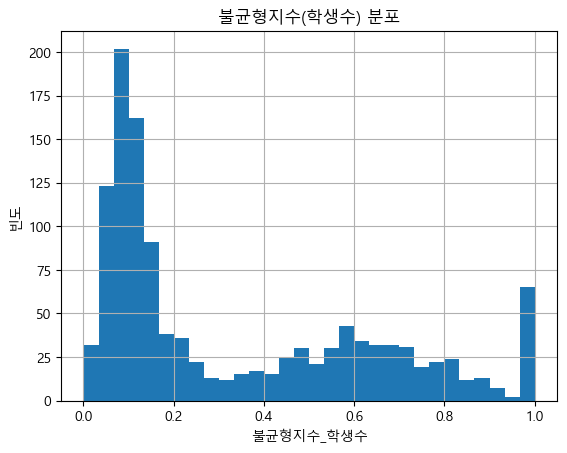

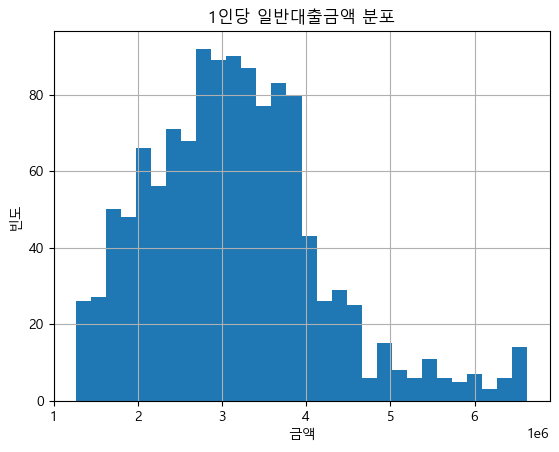

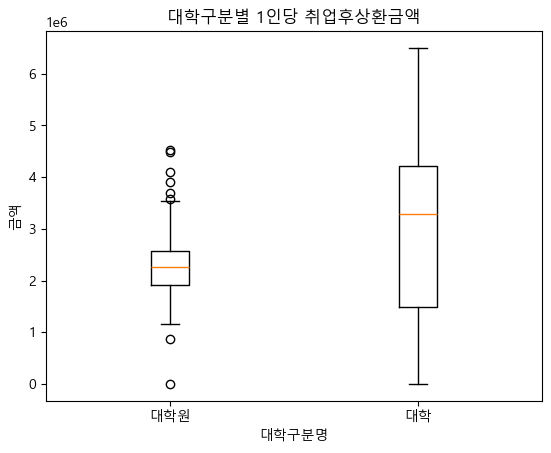

In [33]:
# =======================
# 9) 결과 저장 & 시각화
# =======================
OUT_PATH = "장학재단_전처리_피처엔지니어링.csv"
df.to_csv(OUT_PATH, index=False, encoding="utf-8")
print("Saved to:", OUT_PATH)

import matplotlib.pyplot as plt

# (1) 불균형지수 분포
plt.figure()
df['불균형지수_학생수'].hist(bins=30)
plt.title('불균형지수(학생수) 분포')
plt.xlabel('불균형지수_학생수')
plt.ylabel('빈도')
plt.show()

# (2) 1인당 일반대출금액 분포
plt.figure()
df['1인당_일반대출금액'].hist(bins=30)
plt.title('1인당 일반대출금액 분포')
plt.xlabel('금액')
plt.ylabel('빈도')
plt.show()

# (3) 대학구분별 박스플롯
plt.figure()
group_vals = [g['1인당_취업후상환금액'].dropna().values
              for _, g in df.groupby('대학구분명')]
plt.boxplot(group_vals, tick_labels=df['대학구분명'].unique())  # labels → tick_labels
plt.title('대학구분별 1인당 취업후상환금액')
plt.xlabel('대학구분명')
plt.ylabel('금액')
plt.show()

### D) 추가 시각화 셀 2종

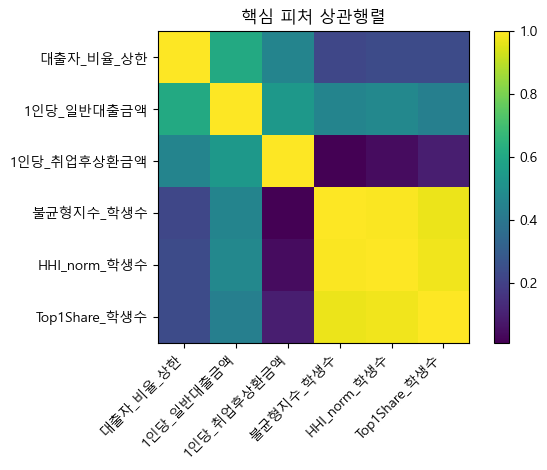

In [37]:
# ===========================================
# D-1) 핵심 피처 상관행렬
# ===========================================
import matplotlib.pyplot as plt
import numpy as np

cols = ['대출자_비율_상한','1인당_일반대출금액','1인당_취업후상환금액',
        '불균형지수_학생수','HHI_norm_학생수','Top1Share_학생수']
corr = df[cols].corr().values

plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
plt.yticks(range(len(cols)), cols)
plt.title('핵심 피처 상관행렬')
plt.colorbar()
plt.tight_layout()
plt.show()


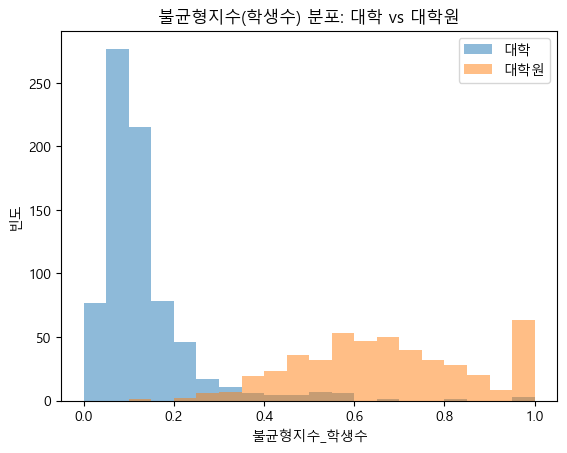

In [38]:
# ===========================================
# D-2) 불균형지수 분포: 대학 vs 대학원
# ===========================================
bins = np.linspace(0, 1, 21)
sub1 = df[df['대학구분명']=='대학']['불균형지수_학생수'].dropna()
sub2 = df[df['대학구분명']=='대학원']['불균형지수_학생수'].dropna()

plt.figure()
plt.hist(sub1, bins=bins, alpha=0.5, label='대학')
plt.hist(sub2, bins=bins, alpha=0.5, label='대학원')
plt.title('불균형지수(학생수) 분포: 대학 vs 대학원')
plt.xlabel('불균형지수_학생수'); plt.ylabel('빈도')
plt.legend()
plt.show()


--------

# 데이터 사전 & 처리 로그

## 데이터 사전(요약)
- `재학생수`: 해당 학기 재학생 수  
- `대출자_비율_상한`: (일반 전체 학생수 + 취업 전체 학생수) / 재학생수 (중복 가능성 고려 상한, 0~1 clip)  
- `1인당_일반대출금액`: 일반학자금 총금액 / 일반학자금 대출자 수  
- `1인당_취업후상환금액`: 취업후상환 총금액 / 취업후상환 대출자 수  
- `일반/취업 × 등록금/생활비_*`: 유형별 학생수·금액 파생(생활비 = 전체 − 등록금, 음수 0 보정)  
- `불균형지수_학생수`: 4유형 분포의 1 − (정규화 엔트로피)  
- `지니_정규화_학생수`: 지니 기반 보조 지표  
- `HHI_학생수`, `HHI_norm_학생수`: 허핀달-허쉬만 지수, 정규화본(0=균등,1=편중)  
- `Top1Share_학생수`: 최다유형 비중  
- `위험군_학생수기준`: 불균형지수 분위수 기준(상위20%=고위험, 20~50%=중위험, 나머지=저위험)  
- `위험군_IQR`: IQR 기반 고위험 라벨(민감도 분석용)

## 처리 로그(요약)
- 중복 제거: (노트북 출력 로그 참조)  
- 결측치: `학교명×대학구분명` 중앙값으로 대체, 잔여 0건  
- 이상치: 1인당 금액 1~99백분위 윈저라이징  
- 합계 일관성: 불일치 건수는 출력 로그에 명시, 분석은 파생치 기준 사용  
- 시각화: 분포/박스플롯/상관행렬/그룹 비교 제공


--------

# 2주차 과제 정리 & 다음 계획

## 이번 주(2주차) 진행 요약
1. **데이터 전처리**
   - `재학생수` 결측치: 학교명×대학구분명 그룹 중앙값으로 대체, 그룹값 없으면 전체 중앙값 보완
   - 중복 행 제거 및 음수 값 검출 → 데이터 품질 점검 수행
   - 이상치(1인당 대출금액): 1~99 백분위 윈저라이징 적용

2. **피처 엔지니어링**
   - **생활비 파생**: (전체 − 등록금), 음수값 0 보정
   - **대출자 비율(상한)**: (일반+취업)/재학생수, clip(0~1)
   - **1인당 평균 대출금액**: 안전한 나눗셈 적용
   - **불균형 지수**: 정규화 엔트로피 기반 산출 (학생수/금액 두 기준)
   - **보조 지표**: 지니 지수, HHI, Top1 비중 추가
   - **위험군 라벨링**: 분위수(상위 20%=고위험, 20~50%=중위험, 나머지=저위험), IQR 기준 병행

3. **시각화**
   - 기본 분포(불균형지수, 1인당 금액), 박스플롯(대학구분별)
   - 추가: 상관행렬 히트맵, 대학 vs 대학원 불균형 분포 비교

4. **결과 저장**
   - 전처리·피처엔지니어링 완료 데이터 CSV(`장학재단_전처리_피처엔지니어링.csv`) 저장
   - 데이터 사전 및 처리 로그 문서화


## 다음 단계
1. **예측 모델링 준비**
   - 입력 변수: 전처리·파생 피처(`대출자 비율`, `1인당 금액`, `불균형지수`, HHI 등)
   - 타겟 변수: 위험군 라벨(`위험군_학생수기준`)
   - 데이터 분할: Train/Test 또는 K-Fold 교차검증

2. **모델링**
   - 기본: 로지스틱 회귀(Logistic Regression) → 해석 가능성 중시
   - 보강: 트리 계열(RandomForest, XGBoost) → 비선형 패턴 학습
   - 성능 비교: Accuracy, F1-score, ROC-AUC

3. **시뮬레이션 & 정책적 활용**
   - 특정 대출 유형(예: 생활비 대출) 증가 시 불균형지수·위험군 분포 변화 시뮬레이션
   - 대학 특성(본교/분교, 대학/대학원, 지역)에 따른 위험군 차이 분석

4. **시각화 확장**
   - 모델 Feature Importance 시각화
   - 위험군 대학 상위 Top-N 리스트 및 지도 시각화(지역별 분석)

## 기대 효과
- 대학별 학자금 대출 구조 불균형을 정량적으로 평가할 수 있는 지표 체계 확립  
- 위험군 대학을 조기 식별 → 정책적 관리·지원의 우선순위 판단 근거 제공  
- 시뮬레이션을 통해 **정책 변화(예: 생활비 대출 확대)**가 불균형 구조에 미치는 영향을 가상 실험 가능